In [11]:
import pyranges as pr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import json
from scipy import stats
from Bio import motifs
from Bio.Seq import Seq
# Display all the columns of dataframes
pd.set_option('display.max_columns', None)

ImportError: Bio.Alphabet has been removed from Biopython. In many cases, the alphabet can simply be ignored and removed from scripts. In a few cases, you may need to specify the ``molecule_type`` as an annotation on a SeqRecord for your script to work correctly. Please see https://biopython.org/wiki/Alphabet for more information.

# Load the STR-eCLIP overlap data

In [2]:
# All STRs within 300 bp of splice sites, and how many peaks each RBP has at each STR
eclip_STR_within_300_df = pd.read_csv("data/temp/eclip_STR_within_300_df.csv")
# All intron-internal STRs and how many peaks each RBP has at each STR
eclip_STR_internal_df = pd.read_csv("data/temp/eclip_STR_internal_df.csv")

In [3]:
with open("data/temp/encode_id2rbp.json") as file:
    encode_id2rbp = json.load(file)

# Check for top binders/replicate consistency

Top 10 site binders

In [4]:
internal_num_peaks = eclip_STR_internal_df.iloc[:,14:].sum()
near_ss_num_peaks = eclip_STR_within_300_df.iloc[:,14:].sum()

internal_num_peaks = internal_num_peaks.rename(index = encode_id2rbp)
near_ss_num_peaks = near_ss_num_peaks.rename(index = encode_id2rbp)

In [5]:
print("eCLIP experiments with most peaks at STRs near splice sites:")
for rbp in near_ss_num_peaks.sort_values(ascending=False)[:10].index.values:
    print(rbp)
print("\n\neCLIP experiments with most peaks at intron-internal STRs:")
for rbp in internal_num_peaks.sort_values(ascending=False)[:10].index.values:
    print(rbp)

eCLIP experiments with most peaks at STRs near splice sites:
DDX3X_HepG2
UCHL5_K562
AQR_K562
PRPF8_HepG2
BCLAF1_HepG2
GRWD1_HepG2
PPIG_HepG2
ZNF622_K562
PRPF4_HepG2
AQR_HepG2


eCLIP experiments with most peaks at intron-internal STRs:
PTBP1_HepG2
PTBP1_K562
HNRNPL_HepG2
PCBP2_HepG2
TARDBP_K562
HNRNPL_K562
EIF4G2_K562
AGGF1_K562
CSTF2T_HepG2
AGGF1_HepG2


### Motifs associated with STR-binding RBPs (from [Dominguez et al., RBNS](https://doi.org/10.1016/j.molcel.2018.05.001), [Transite](https://transite.mit.edu/), or [CISBP-RNA](http://cisbp-rna.ccbr.utoronto.ca/))

None of the near-splice-site-binding RBPs have known motifs from them from the above 3 databases. 

1. PTBP1: AGAHHUYYYHYHYYY (polypyrimidine tract)
2. HNRNPL: ACACAMA
3. PCBP2: CCYYCCC
4. TARDBP: DGAAUGAD
5. EIF4G2 (elongation initiation)
6. AGGF1
7. CSTF2T (CSTF2 binds GU-rich)

### Get STR motifs associated with these RBPs
Note that this is simply the "class" of the STR bound by this protein, and not the actual repeat! That's why the logo plots all have a really strong "A" at the beginning. All the motif classes start with A. Moreover, Biopython motif doesn't support RNA :'( so we have T instead of U. 

In [13]:
encode_rbp2id = {v:k for k,v in zip(encode_id2rbp.keys(), encode_id2rbp.values())}

near_ss_RBPs = ["DDX3X_HepG2", "UCHL5_K562", "AQR_K562", "PRPF8_HepG2",
                "BCLAF1_HepG2", "GRWD1_HepG2", "PPIG_HepG2","ZNF622_K562",
                "PRPF4_HepG2","AQR_HepG2"]
internal_RBPs = ["PTBP1_HepG2", "PTBP1_K562", "HNRNPL_HepG2", "PCBP2_HepG2",
                 "TARDBP_K562", "HNRNPL_K562","EIF4G2_K562","AGGF1_K562",
                 "CSTF2T_HepG2","AGGF1_HepG2"]

ss_motif_dict = {}
for RBP in near_ss_RBPs:
    encode_id = encode_rbp2id[RBP]
    motif_list = list(eclip_STR_within_300_df[eclip_STR_within_300_df[encode_id]>0]["class"])
    # turn the STR list into a list of hexamers
    motif_list = [6*x for x in motif_list]
    motif_list = [Seq(x[:6]) for x in motif_list]
    # make a Biopython motif out of the list and store it
    current_motif = motifs.create(motif_list)
    ss_motif_dict[RBP] = current_motif
    
internal_motif_dict = {}
for RBP in internal_RBPs:
    encode_id = encode_rbp2id[RBP]
    motif_list = list(eclip_STR_internal_df[eclip_STR_internal_df[encode_id]>0]["class"])
    # turn the STR list into a list of hexamers
    motif_list = [6*x for x in motif_list]
    motif_list = [Seq(x[:6]) for x in motif_list]
    # make a Biopython motif out of the list and store it
    current_motif = motifs.create(motif_list)
    internal_motif_dict[RBP] = current_motif

In [15]:
for key in ss_motif_dict:
    fname = f"data/3_eCLIP_motifs/near_ss_{key}.png"
    print(f"Saving {fname}...")
    ss_motif_dict[key].weblogo(fname)

for key in internal_motif_dict:
    fname = f"data/3_eCLIP_motifs/internal_{key}.png"
    print(f"Saving {fname}...")
    internal_motif_dict[key].weblogo(fname)

Saving data/3_eCLIP_motifs/near_ss_DDX3X_HepG2.png...
Saving data/3_eCLIP_motifs/near_ss_UCHL5_K562.png...
Saving data/3_eCLIP_motifs/near_ss_AQR_K562.png...
Saving data/3_eCLIP_motifs/near_ss_PRPF8_HepG2.png...
Saving data/3_eCLIP_motifs/near_ss_BCLAF1_HepG2.png...
Saving data/3_eCLIP_motifs/near_ss_GRWD1_HepG2.png...
Saving data/3_eCLIP_motifs/near_ss_PPIG_HepG2.png...
Saving data/3_eCLIP_motifs/near_ss_ZNF622_K562.png...
Saving data/3_eCLIP_motifs/near_ss_PRPF4_HepG2.png...
Saving data/3_eCLIP_motifs/near_ss_AQR_HepG2.png...
Saving data/3_eCLIP_motifs/internal_PTBP1_HepG2.png...
Saving data/3_eCLIP_motifs/internal_PTBP1_K562.png...
Saving data/3_eCLIP_motifs/internal_HNRNPL_HepG2.png...
Saving data/3_eCLIP_motifs/internal_PCBP2_HepG2.png...
Saving data/3_eCLIP_motifs/internal_TARDBP_K562.png...
Saving data/3_eCLIP_motifs/internal_HNRNPL_K562.png...
Saving data/3_eCLIP_motifs/internal_EIF4G2_K562.png...
Saving data/3_eCLIP_motifs/internal_AGGF1_K562.png...
Saving data/3_eCLIP_motifs/

### Observations about the above LOGOs
1. In general, good agreement of motif for the same RBP between bio replicates
2. Among intron-internal, lots of AC-rich motifs 
3. Among near-ss, PPIG_HepG2, GRWD1_HepG2, BCLAF1_HepG2, UCLH5_K562, ZNF622 all similar. 
4. Near-ss PRPF4_HepG2, PRPF8_HepG2 kind of similar. 
5. Near-ss DDX3X unique: looks like ASSSSS. 

### Motif consistency at intron-internal
|Consistent|Inconsistent|
|----------|------------|
|HNRNPL (ACACAC) |PTBP1 (AAAGAA)|
||PCBP2 (AGGGGG)|
||TARDBP (ACACAC)|
||CSTF2T|

PTBP1 especially worrying, since it shows binding to purine-rich motif ... did I mess up the strands?

### Where these RBPs bind according to Van Nostrand et al

The classes of the near-splice-site RBPs. Most are class 1 (CDS), some class 2, 4, 5 (CDS+other, intron, 5'SS). Interesting that so many are usually associated with CDS...

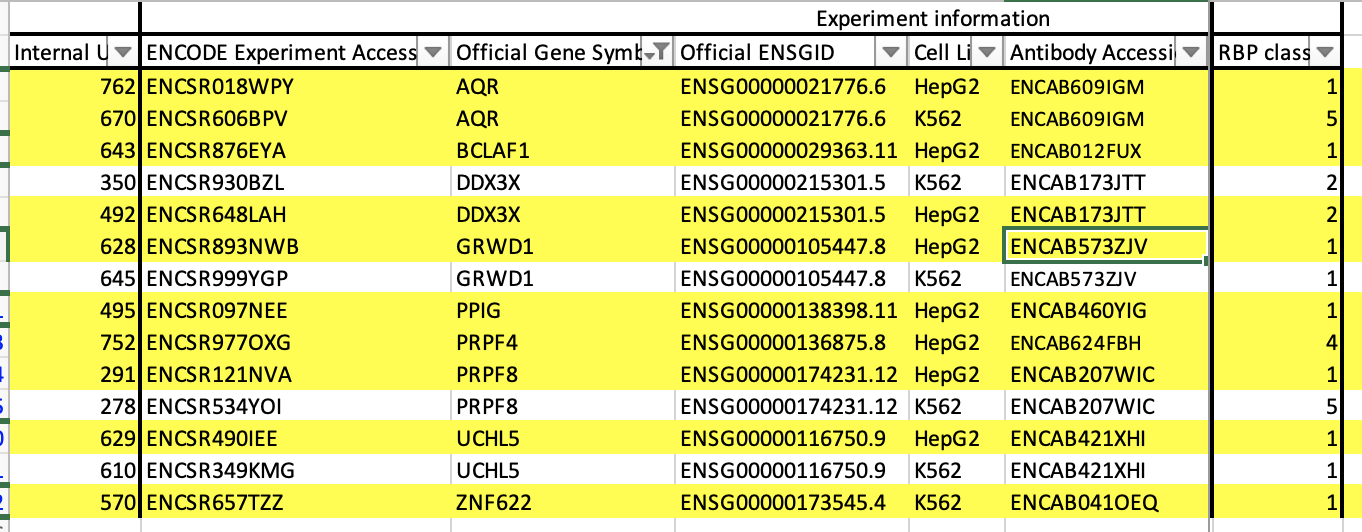

Classes of intron-internal RBPs are all class 4 (intron). This is consistent. 

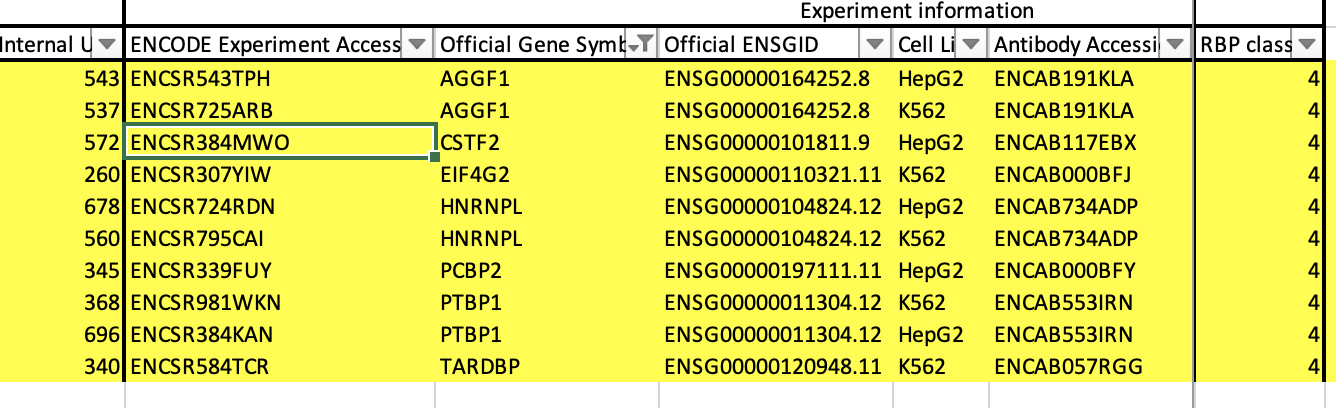

# Comparison of biological replicates

In [ ]:
near_ss_HepG2 = pd.DataFrame({"ss_HepG2": near_ss_num_peaks.filter(regex = r'HepG2').rename(lambda x: x.rstrip('_HepG2'))})
near_ss_K562 = pd.DataFrame({"ss_K562": near_ss_num_peaks.filter(regex = r'K562').rename(lambda x: x.rstrip('_K562'))})
internal_HepG2 = pd.DataFrame({"internal_HepG2": internal_num_peaks.filter(regex = r'HepG2').rename(lambda x: x.rstrip('_HepG2'))})
internal_K562 = pd.DataFrame({"internal_K562": internal_num_peaks.filter(regex = r'K562').rename(lambda x: x.rstrip('_K562'))})

In [ ]:
peak_count_df = near_ss_HepG2.join([near_ss_K562, internal_HepG2, internal_K562], how = "inner")

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,6))
ax2.scatter(peak_count_df["ss_HepG2"], peak_count_df["ss_K562"])
ax1.scatter(peak_count_df["internal_HepG2"], peak_count_df["internal_K562"])
ax2.set(xlabel = "HepG2", ylabel = "K562", title = "near_ss", xscale = 'log', yscale = 'log')
ax1.set(xlabel = "HepG2", ylabel = "K562", title = "intron_internal", xscale = 'log', yscale = 'log')
# Add a pseudocount of +1 here
ss_regress = stats.linregress(np.log(peak_count_df["ss_HepG2"]+1), np.log(peak_count_df["ss_K562"]+1))
internal_regress = stats.linregress(np.log(peak_count_df["internal_HepG2"]+1), np.log(peak_count_df["internal_K562"]+1))
print(f"internal R^2: {internal_regress.rvalue**2:.2f}")
print(f"near_ss R^2: {ss_regress.rvalue**2:.2f}")

Both R^2 values are better than what we see in Extended Data Fig. 1h of Van Nostrand (0.47)

# Quick intron-internal vs ss analysis

In [ ]:
within_300_STR = pr.PyRanges(pd.read_csv("data/temp/within_300_ss_pyranges.csv"))
intron_internal_STR = pr.PyRanges(pd.read_csv("data/temp/intron_internal_pyranges.csv"))

In [ ]:
num_ss_STR = len(within_300_STR)
num_intron_internal_STR = len(intron_internal_STR)
peak_count_df["fraction_ss_combined"] = (peak_count_df["ss_HepG2"]+peak_count_df["ss_K562"])/num_ss_STR
peak_count_df["fraction_internal_combined"] = (peak_count_df["internal_HepG2"]+peak_count_df["internal_K562"])/num_intron_internal_STR
peak_count_df

In [ ]:
fig, ax = plt.subplots()
ax.boxplot([peak_count_df['fraction_internal_combined'], peak_count_df['fraction_ss_combined']], 
           labels = ['intron-internal', 'near SS'])
ax.set(ylabel = 'Fraction of STRs in category')

In [ ]:
stats.mannwhitneyu(peak_count_df['fraction_internal_combined'], peak_count_df['fraction_ss_combined'])

# Toy RBP enrichment
Compare binding to motifs near splice sites, near STRs vs. motifs near splice sites that aren't STRs

In [ ]:
eclip_STR_internal_df

In [ ]:
# for a single RBP/collection of RBPs
# n = # STR peaks near ss with motif
# m = # STRs near ss with motif
# x = # total peaks near SS for that RBP
# y = # total loci near ss where RBP could bind
# 
#                   peak        no peak    total 
#     STR near ss   n             m-n        m
# not STR near ss   x-n           y-x-m+n    y-m
# total             x             y-x        y


# set the RBPs we're looking at 
rbp_experiment_list = ['HNRNPC_K562', 'HNRNPC_HepG2']
# get a PyRanges of their motifs near SS genome-wide
# open ucsc transcript data
# make a dict of motifs for our RBPs
# for each RBP:
    # get the eCLIP PyRanges
    # get n from overlap between within_300 PyRanges and eCLIP PyRanges for that RBP (include motif and strand info?)
    # get m from within_300 PyRanges
    # get y from the PyRanges before the loop
    # get x from overlap between PyRanges before loop and eCLIP PyRanges